# August 13th, 2018
## Benjamin Adam Catching
## Andino Lab
## Polio-virus DIPs Project

In [102]:
# Import necessary packages
import glob
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import seaborn as sns
import skimage
import scipy.ndimage as ndi
import scipy
import pandas as pd
import os

From the bulk data in the _07.27_HeLa_Tip_Hong_ files;  
* Process the images to yeild individual cell expression/non-expression of GFP  
* Output relevant cell data to dataframe (save as .csv)  
* Exploratory Data Analysis using visualization of cell intensity
* Analysis the variance data using resampling (both bootstrapping and exact test)  
* Analysis of the data with Pearson correlation between experiment (DIP vs. PV1)  
  and GFP expression

In [2]:
# Define the location of the files
bulk_cell_dir = 'data/07.27_HeLa_TIP_Hong/'

# Define the six directories that contain image files
set_1 = '#1/10x-[0-9].tif'
set_2 = '#2/10x-[0-9].tif'
set_3 = '#3/10x-[0-9].tif'
set_4 = '#4/10x-[0-9].tif'
set_5 = '#5/10x-[0-9].tif'

In [3]:
# Read in the files
group_1 = sorted(glob.glob(bulk_cell_dir + set_1))
group_2 = sorted(glob.glob(bulk_cell_dir + set_2))
group_3 = sorted(glob.glob(bulk_cell_dir + set_3))
group_4 = sorted(glob.glob(bulk_cell_dir + set_4))
group_5 = sorted(glob.glob(bulk_cell_dir + set_5))

In [4]:
group_1

['data/07.27_HeLa_TIP_Hong/#1/10x-1.tif',
 'data/07.27_HeLa_TIP_Hong/#1/10x-2.tif',
 'data/07.27_HeLa_TIP_Hong/#1/10x-3.tif']

In [5]:
# Import microfluidics_analysis from tools
from tools import microfluidics_analysis as ma

In [103]:
# Test the newer 10X image processing script on group 1 (PI + DIP)
temp_data = ma.segment_10x(group_1[0])
temp_droplets, temp_gfp, temp_bw = temp_data
temp_data = None
print(len(temp_droplets))

163


The random number is 15


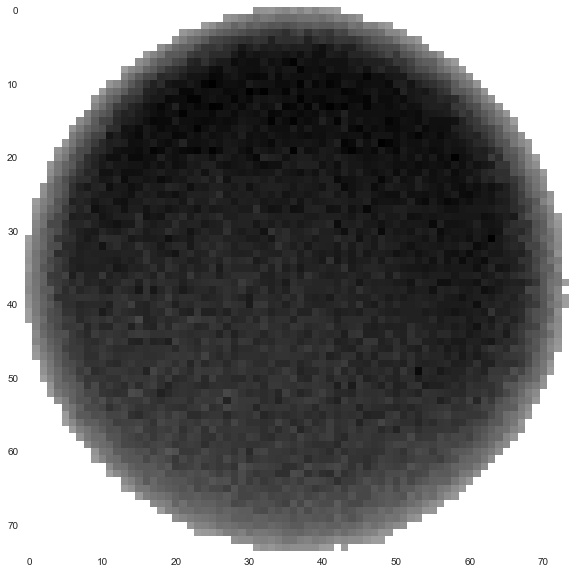

In [7]:
# Display a random droplet

# Get random number
rand_num = np.random.randint(len(temp_droplets))
print('The random number is %d' % rand_num)
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    _ = plt.imshow(temp_droplets[rand_num])
    plt.show()

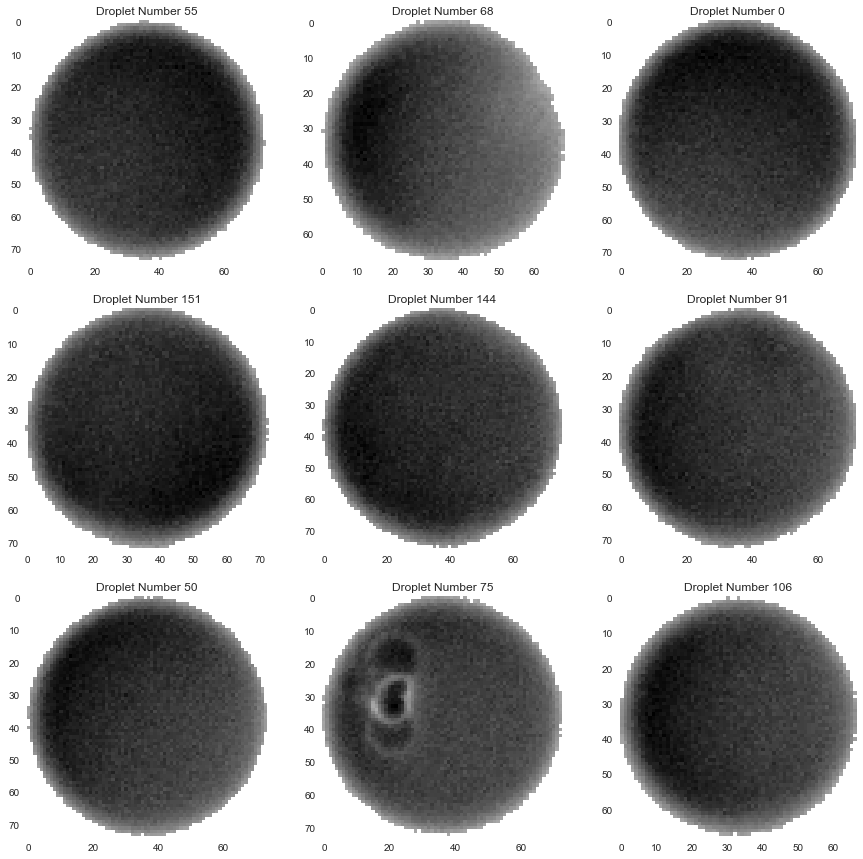

In [8]:
# Display a random droplet

# Define the number of rows
num_rows = 3
num_cols = 3

# Get random numbers in correct shape
random_nums = np.random.randint(len(temp_droplets), size=(num_rows, num_cols))

with sns.axes_style('dark'):
    fig, ax = plt.subplots(num_rows, 
                           num_cols, 
                           figsize=(5*num_cols, 5*num_rows))
    for i in range(num_rows):
        for j in range(num_cols):
            rand_cell = random_nums[i, j]
            _ = ax[i, j].imshow(temp_droplets[rand_cell])
            _ = ax[i, j].set_title('Droplet Number %d' % rand_cell)
            
    plt.show()

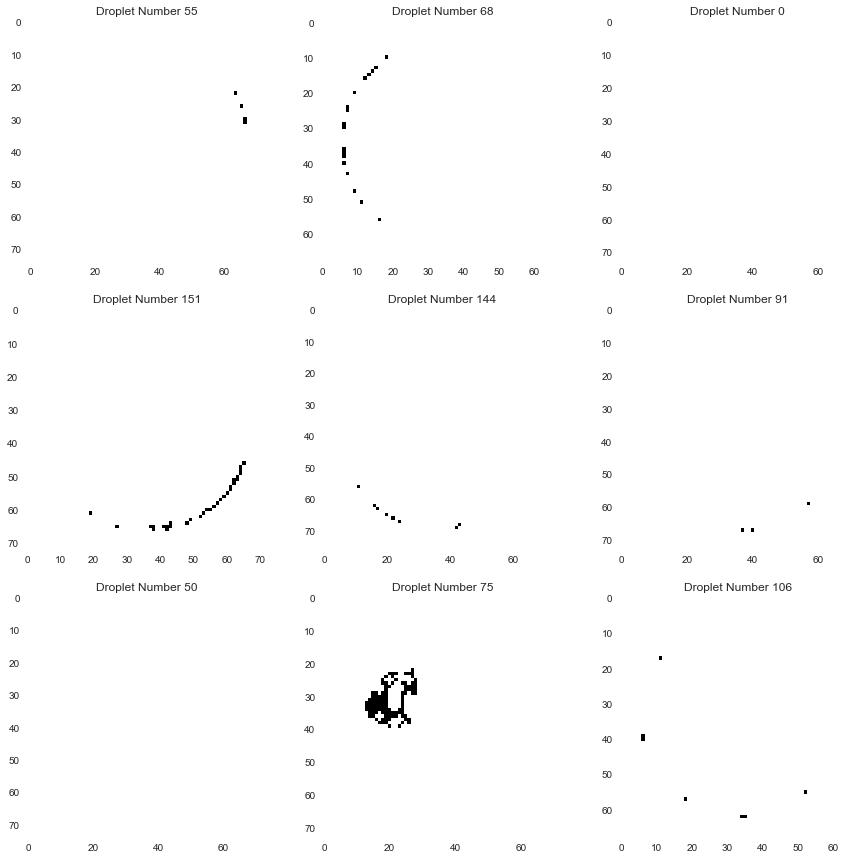

In [9]:
# Perform the same display of the cells (some may be still merged)
# and use this as the basis to separate cells using the watershed/random walk
# method

with sns.axes_style('dark'):
    fig, ax = plt.subplots(num_rows, 
                           num_cols, 
                           figsize=(5*num_cols, 5*num_rows))
    for i in range(num_rows):
        for j in range(num_cols):
            rand_cell = random_nums[i, j]
            _ = ax[i, j].imshow(temp_bw[rand_cell])
            _ = ax[i, j].set_title('Droplet Number %d' % rand_cell)
            
    plt.show()

The script can only recognize two separate cells, not two cells nearby. Additional modification will be necessary to allow for nearby cell recognition.

In [12]:
def segment_10x(filename):
    """
    Based on the images collected by Hong in July, this function takes the
    merged bright-field/GFP image of the bulk, 10X images of infected/uninfected
    cells and returns a list of the individual droplets and their bright-field
    and GFP identified cells.

    Parameters
    ----------
    filename:
        The RGB .tif file that contains the GFP channel (1) and bright-field
        channel (0)

    Return
    ------
    whole_droplets:
        A list of grey-scale 2D numpy arrays representing the bright-field
        images of identified droplets
    gfp_droplets:
        A list of grey-scale 2D numpy arrays that represent the GFP image of
        each cell
    bw_droplets:
        A list of grey-scale 2D numpy arrays that represent the individual
        cells in a droplet
    """
    # Read in the bright-field and GFP images
    image_bright = skimage.io.imread(filename)[:, :, 0]
    image_gfp = skimage.io.imread(filename)[:, :, 1]
    # Find the Otsu threshold
    bright_thresh_otsu = skimage.filters.threshold_otsu(image_bright)

    # Label thresholded images
    bright_threshold = image_bright > bright_thresh_otsu
    image_labeled, number_labels = skimage.measure.label(bright_threshold,
                                                         background=0,
                                                         return_num=True)

    # Get the properties of the labeled regions
    image_props = skimage.measure.regionprops(image_labeled)

    # Create a blank region of the original image
    image_dimensions = image_bright.shape
    blank_background = np.zeros(image_dimensions)
    # Go through props
    for index, prop in enumerate(image_props):
        # If the region properties are within the threshold
        if prop.area >= 400 and prop.eccentricity <= 0.5:
            # Select the region
            temp_seg = image_labeled == index + 1
            filled_seg = temp_seg
            # Add the temp region
            blank_background = blank_background + filled_seg

    # Fill the holes of the image
    image_droplets = scipy.ndimage.binary_fill_holes(blank_background)

    # From the filled droplets, create labeled regions with properties
    labeled_droplets, number_droplets = skimage.measure.label(image_droplets,
                                                              background=0,
                                                              return_num=True)
    bright_droplet_props = skimage.measure.regionprops(labeled_droplets,
                                                       image_bright)
    gfp_droplet_props = skimage.measure.regionprops(labeled_droplets,
                                                    image_gfp)
    # List to save black-white threshold cells
    whole_droplets = []
    bw_droplets = []
    gfp_droplets = []
    for i in range(number_droplets):
        # Add brightfield image and gfp to lists
        whole_droplets.append(bright_droplet_props[i].intensity_image)
        gfp_droplets.append((gfp_droplet_props[i].intensity_image > 150)
                            * gfp_droplet_props[i].intensity_image)
        # Define the brightfield image
        temp_image = bright_droplet_props[i].intensity_image
        droplet_mask = bright_droplet_props[i].image
        # Define the inner radius of the droplet
        primary_radius = bright_droplet_props[i].minor_axis_length / 2
        new_radius = primary_radius - 5

        if len(droplet_mask) < len(droplet_mask[0]):
            center_x = bright_droplet_props[i].minor_axis_length / 2
            center_y = bright_droplet_props[i].major_axis_length / 2
        else:
            center_x = bright_droplet_props[i].major_axis_length / 2
            center_y = bright_droplet_props[i].minor_axis_length / 2

        new_mask = np.zeros(droplet_mask.shape)
        for x, row in enumerate(new_mask):
            for y, pixel in enumerate(row):
                dist_x = center_x - x
                dist_y = center_y - y
                dist = np.sqrt(dist_x ** 2 + dist_y ** 2)
                if dist < new_radius:
                    new_mask[x, y] = 1

        elevation_map = skimage.filters.sobel(temp_image, droplet_mask)
        # Otsu threshold the Scharr image
        cell_droplet_thresh = skimage.filters.threshold_otsu(elevation_map)
        edges = elevation_map > cell_droplet_thresh
        edges = skimage.morphology.erosion(edges)
        # Label the parts of the image and threshold if radius
        label = skimage.measure.label(edges, background=0)
        edge_props = skimage.measure.regionprops(label, temp_image)
        image_dimensions = temp_image.shape
        blank_background = np.zeros(image_dimensions)
        # print('Droplet %d' % (i*3 + j))
        for index, prop in enumerate(edge_props):
            cutoff = prop.extent
            # print(prop.equivalent_diameter, cutoff)
            if prop.area > 10:
                # print(prop.area)
                temp_seg = label == index + 1
                filled_seg = temp_seg
                blank_background = blank_background + filled_seg

        # Remove outer ring
        cells = blank_background * new_mask
        """
        cells = skimage.morphology.dilation(cells)
        cells = skimage.morphology.closing(cells)
        cells = scipy.ndimage.binary_fill_holes(cells)
        cells = skimage.morphology.erosion(cells)
        cells = skimage.morphology.erosion(cells)
        """
        # Append the cells image to the list
        bw_droplets.append(cells)


    return whole_droplets, gfp_droplets, bw_droplets

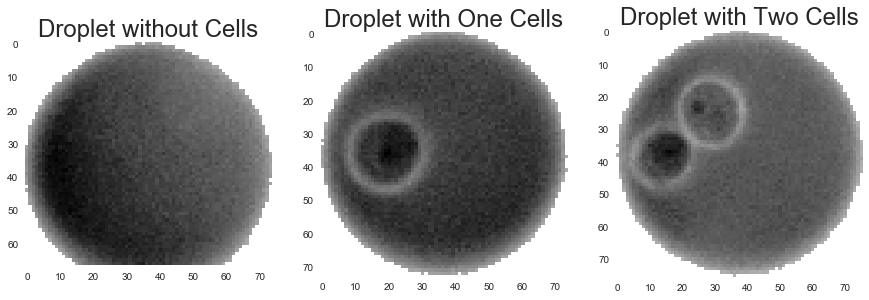

In [10]:
# Work on the 10X segmentation script
test_droplets = [temp_droplets[x] for x in [162, 139, 128]]

with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    _ = ax[0].imshow(test_droplets[0])
    _ = ax[0].set_title('Droplet without Cells', size=24)
    _ = ax[1].imshow(test_droplets[1])
    _ = ax[1].set_title('Droplet with One Cells', size=24)
    _ = ax[2].imshow(test_droplets[2])
    _ = ax[2].set_title('Droplet with Two Cells', size=24)
    plt.show()

/Users/adam/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


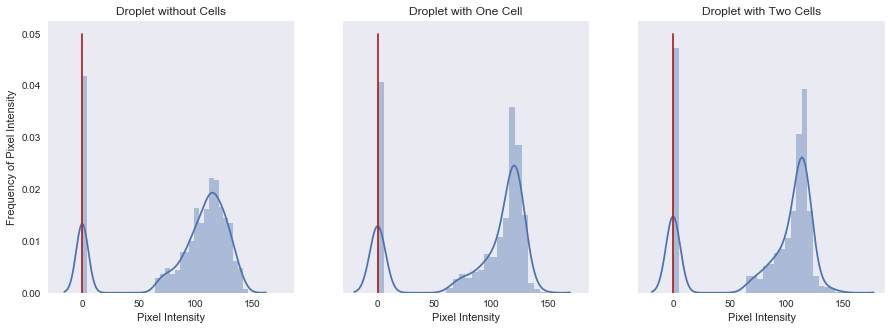

In [11]:
# See if there is a difference in the intensity histograms of the three 
# different types of droplets
test_droplet_ints = [x.flatten() for x in test_droplets]
three_types = ['Droplet without Cells', 
               'Droplet with One Cell', 
               'Droplet with Two Cells']

with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    ax[0].set_ylabel('Frequency of Pixel Intensity')
    for i in range(3):
        # Find the Otsu threshold for each distribution
        temp_otsu = skimage.filters.threshold_otsu(test_droplet_ints[i])
        _ = sns.distplot(test_droplet_ints[i], ax=ax[i])
        _ = ax[i].set_title(three_types[i])
        _ = ax[i].set_xlabel('Pixel Intensity')
        _ = ax[i].plot([temp_otsu, temp_otsu], [0, .05], color='firebrick')
    plt.show()

The spike at 0 may be confusing the Otsu algorithm. Remove values of 0 from the flattened intensity lists.

In [12]:
non_zero_droplet_ints = [np.array([x for x in y if x != 0]) for y in test_droplet_ints]
non_zero_droplet_ints[0]

array([70, 67, 69, ..., 78, 77, 65], dtype=uint8)

/Users/adam/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


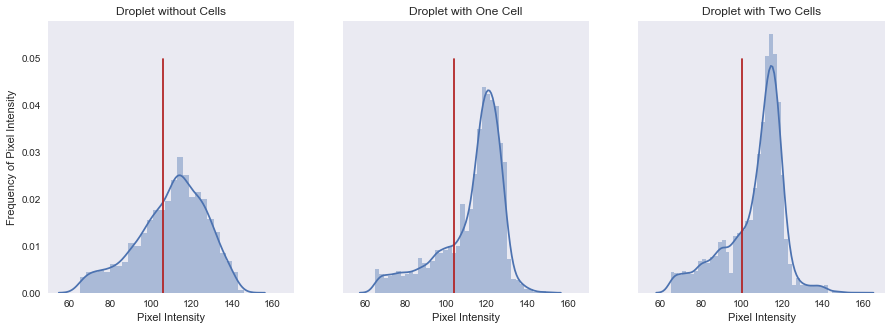

In [13]:
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    ax[0].set_ylabel('Frequency of Pixel Intensity')
    for i in range(3):
        # Find the Otsu threshold for each distribution
        temp_otsu = skimage.filters.threshold_otsu(non_zero_droplet_ints[i])
        _ = sns.distplot(non_zero_droplet_ints[i], ax=ax[i])
        _ = ax[i].set_title(three_types[i])
        _ = ax[i].set_xlabel('Pixel Intensity')
        _ = ax[i].plot([temp_otsu, temp_otsu], [0, .05], color='firebrick')
    plt.show()

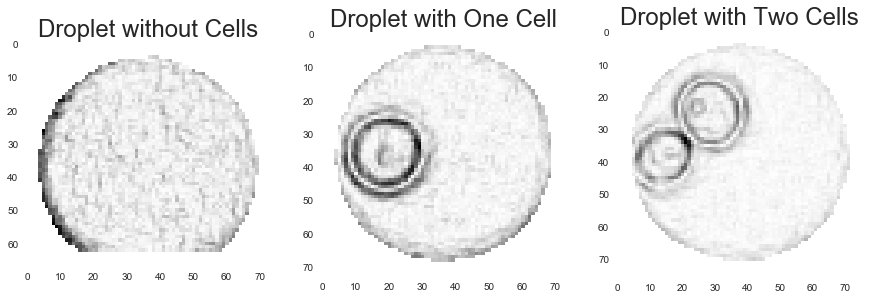

In [114]:
# See if the values change when the scharr method is applied
# Create list of masks
temp_masks = [np.array(y != 0) for y in test_droplets]
temp_masks = [ndi.binary_erosion(x, iterations=3) for x in temp_masks]
temp_sobel = [skimage.filters.prewitt(x, temp_masks[i]) for i, x in enumerate(test_droplets)]
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        # Find the Otsu threshold for each distribution
        _ = ax[i].imshow(temp_sobel[i])
        _ = ax[i].set_title(three_types[i], size=24)
    plt.show()

/Users/adam/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


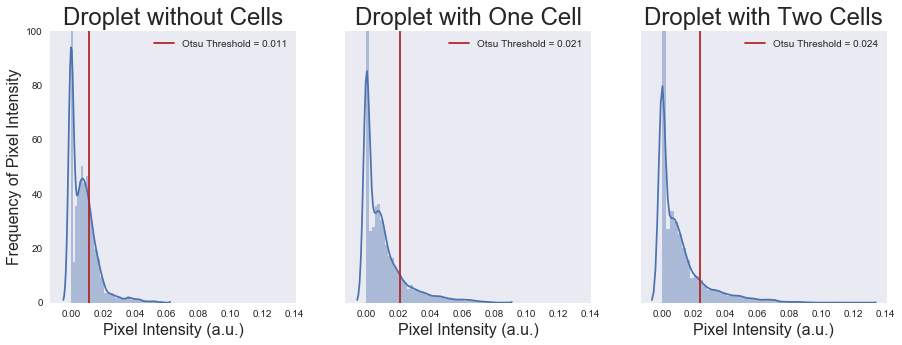

In [138]:
# Save otsu thresholds
post_scharr_otsu = []
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    ax[0].set_ylabel('Frequency of Pixel Intensity', size=16)
    for i in range(3):
        # Find the Otsu threshold for each distribution
        temp_otsu = round(skimage.filters.threshold_otsu(temp_sobel[i]), 3)
        temp_flatten = temp_sobel[i].flatten()
        #non_zero_flatten = [x for x in temp_flatten if x != 0]
        #temp_otsu = skimage.filters.threshold_otsu(non_zero_flatten)
        post_scharr_otsu.append(temp_otsu)
        _ = sns.distplot(temp_flatten, ax=ax[i])
        _ = ax[i].set_ylim((0, 100))
        _ = ax[i].set_title(three_types[i], size=24)
        _ = ax[i].set_xlabel('Pixel Intensity (a.u.)', size=16)
        # First time using f-strings. So cool!
        otsu_thresh_name = f'Otsu Threshold = {temp_otsu}'
        _ = ax[i].plot([temp_otsu, 
                       temp_otsu], 
                       [0, 350], 
                       color='firebrick', 
                       label=otsu_thresh_name)
        _ = ax[i].legend()
        
    plt.show()

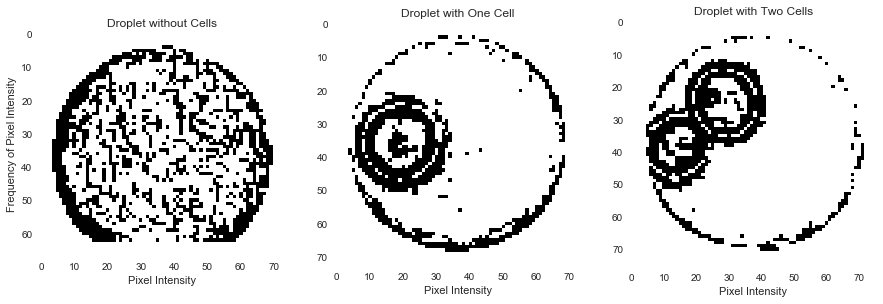

In [140]:
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].set_ylabel('Frequency of Pixel Intensity')
    thresh_droplets = [None] * 3
    for i in range(3):
        # Threshold the droplets only the masked region
        thresh_droplets[i] = temp_sobel[i] > post_scharr_otsu[i]
        _ = ax[i].imshow(thresh_droplets[i])
        _ = ax[i].set_title(three_types[i])
        _ = ax[i].set_xlabel('Pixel Intensity')
        #_ = ax[i].plot([temp_otsu, temp_otsu], [0, .05], color='firebrick')
    plt.show()

In [112]:
# Get the region properties of the droplets
labels = [skimage.measure.label(x, background=0) for x in thresh_droplets]
edge_props = [skimage.measure.regionprops(x) for x in labels]

In [48]:
# Show the distribution of eccentricity
blank_regions = [np.zeros(x.shape) for x in thresh_droplets]
for i in range(3):
    for index, prop in enumerate(edge_props[i]):
        if prop.area > 50 and prop.eccentricity <= 0.9:
            print(prop.area, prop.eccentricity)
            temp_seg = labels[i] == index + 1
            print(index)
            blank_regions[i] = blank_regions[i] + temp_seg


346 0.36716206597508266
14
530 0.838786752475231
7


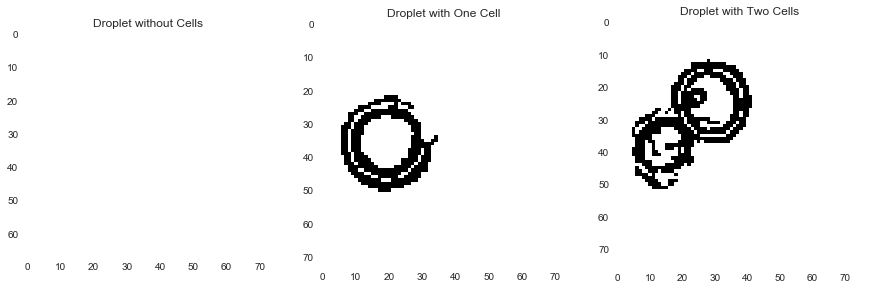

In [109]:
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        _ = ax[i].imshow(blank_regions[i])
        _ = ax[i].set_title(three_types[i])
    plt.show()

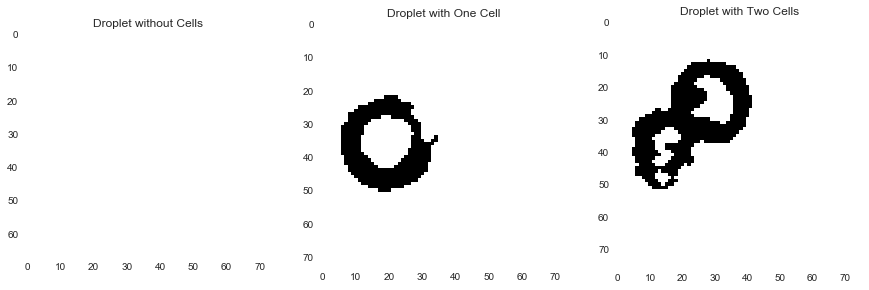

In [50]:
# Close openings
temp_close = [ndi.binary_closing(x) for x in blank_regions]
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        _ = ax[i].imshow(temp_close[i])
        _ = ax[i].set_title(three_types[i])
    plt.show()

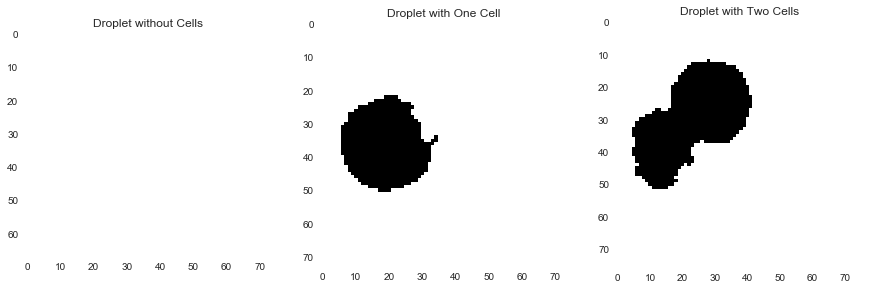

In [51]:
# Fill any holes
temp_fill = [ndi.binary_fill_holes(x) for x in temp_close]
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        _ = ax[i].imshow(temp_fill[i])
        _ = ax[i].set_title(three_types[i])
    plt.show()

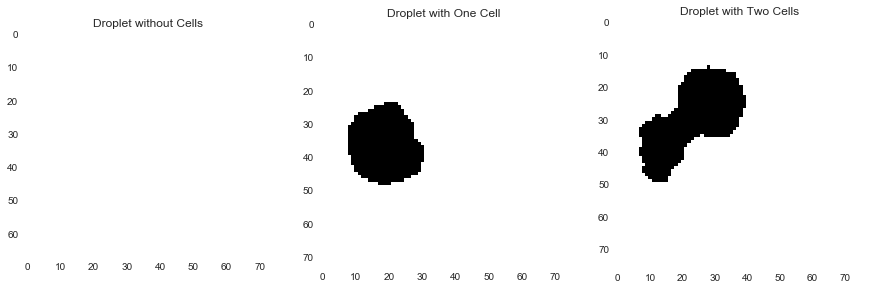

In [52]:
# Erode the exterior region
temp_final = [ndi.binary_erosion(x, iterations=2) for x in temp_fill]
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        _ = ax[i].imshow(temp_final[i])
        _ = ax[i].set_title(three_types[i])
    plt.show()

/Users/adam/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
  # This is added back by InteractiveShellApp.init_path()


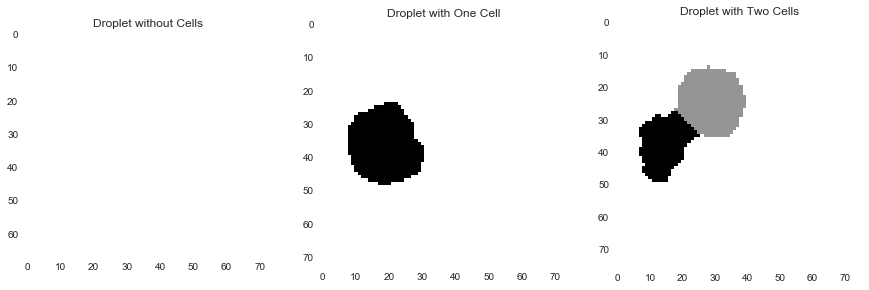

In [101]:
# Use watershed to determine whether there are one cell or two cells
temp_distances = [ndi.distance_transform_edt(x) for x in temp_final]

local_maxi = [skimage.feature.peak_local_max(x,
                                             indices=False,
                                             footprint=np.ones((15, 15)),
                                             labels=temp_final[i]) 
              for i, x in enumerate(temp_distances)]
markers = [skimage.measure.label(x) for x in local_maxi]

cell_labels = [skimage.segmentation.watershed(-x, markers[i], mask=x) for i, x in enumerate(temp_final)]

with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        _ = ax[i].imshow(cell_labels[i])
        _ = ax[i].set_title(three_types[i])
    plt.show()